<a href="https://colab.research.google.com/github/duwi27sulis/Peramalan-LSTM_85-15/blob/main/Update_75_25_H2_T12_Fix_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 4.2 MB/s eta 0:00:00


In [2]:
# Package
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import optuna
from optuna.visualization.matplotlib import plot_optimization_history, plot_param_importances
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop, SGD

In [3]:
# Fix random seed for reproducibility
tf.random.set_seed(42)
plt.rcParams['figure.figsize'] = (12,6)

In [4]:
# Input Data
url = "https://raw.githubusercontent.com/duwi27sulis/Analisis_Data_LSTM/main/Ekspor-Migas-2001-2023.csv"
df = pd.read_csv(url, sep=",")
df['Tanggal'] = pd.to_datetime(df.Tanggal)
data = df['Nilai Ekspor Migas'].values.astype('float32').reshape(-1, 1)

In [5]:
# Statistik Deskriptif
df['Nilai Ekspor Migas'].describe()

,Nilai Ekspor Migas
count,276.000000
mean,1676.342029
std,768.702279
min,560.900000
25%,1122.675000
50%,1422.750000
75%,2101.000000
max,4091.600000


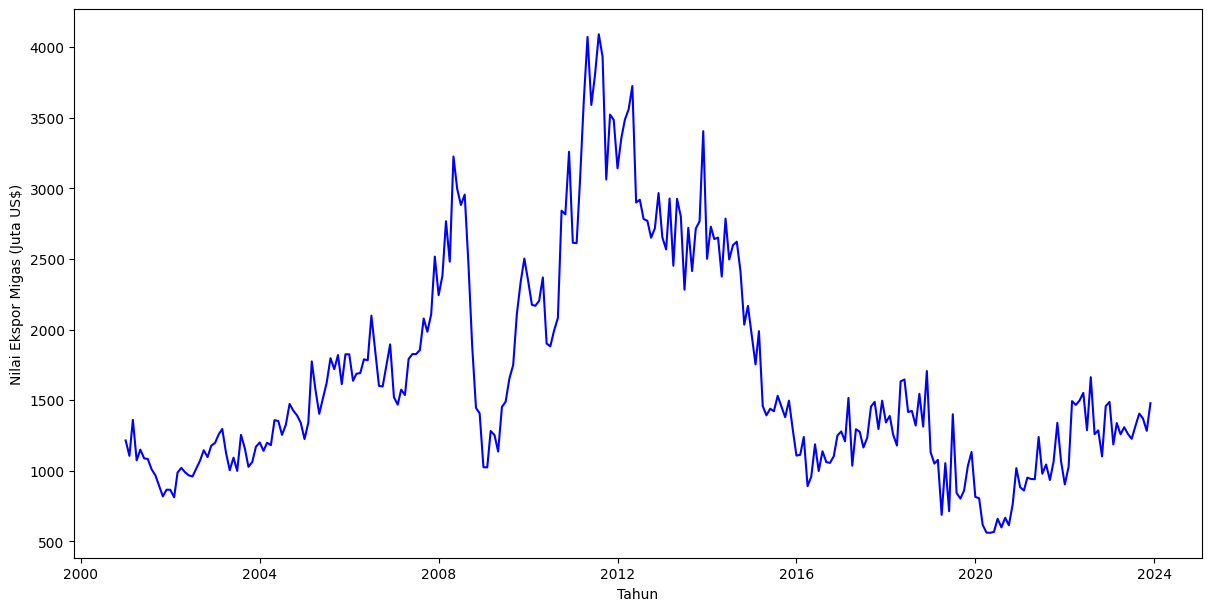

In [6]:
# Line plot data time series
from matplotlib import pyplot as plt
import seaborn as sns

def _plot_series(series, series_name, series_index=0):
    xs = series['Tanggal']
    ys = series['Nilai Ekspor Migas']

    plt.plot(xs, ys, label=series_name, color='blue')

fig, ax = plt.subplots(figsize=(12, 6), layout='constrained')
df_sorted = df.sort_values('Tanggal', ascending=True)
_plot_series(df_sorted, '')

# Menambahkan bingkai kotak
ax.spines['top'].set_visible(True)
ax.spines['right'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)

sns.despine(fig=fig, ax=ax, top=False, right=False, bottom=False, left=False)
plt.xlabel('Tahun')
_ = plt.ylabel('Nilai Ekspor Migas (Juta US$)')

plt.show()

In [7]:
# Uji kestasioneran (Augmented Dickey-Fuller Test)
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf

result_original = sm.tsa.adfuller(data)
print('ADF Statistic :', result_original[0])
print('p-value :', result_original[1])
print('Critical :')
for key, value in result_original[4].items():
    print(f'   {key}: {value}')

ADF Statistic : -2.0481781387920948
p-value : 0.2658560561741424
Critical :
   1%: -3.4544435065994437
   5%: -2.8721468827772774
   10%: -2.572422013959188


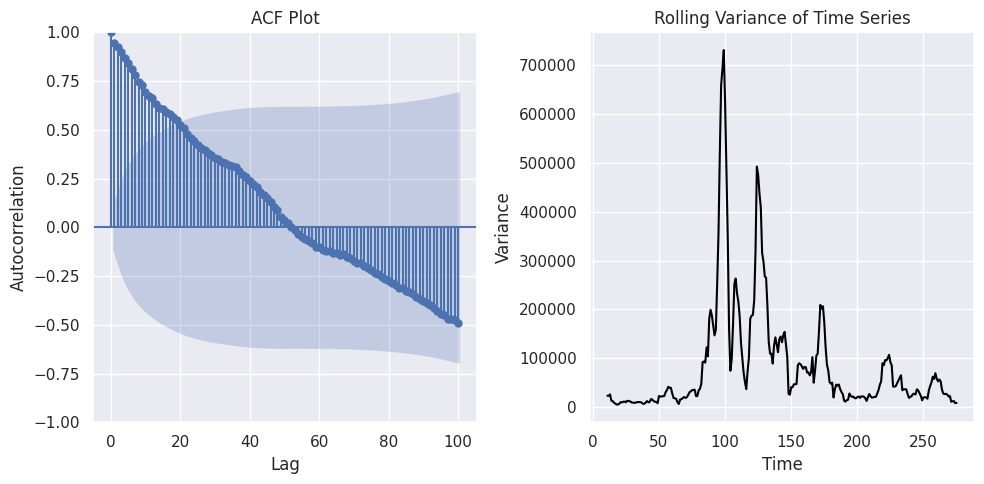

In [8]:
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf

# Mengatur gaya seaborn
sns.set()

# Mengambil kolom 'Nilai Ekspor Migas' sebagai series
series = df['Nilai Ekspor Migas']

# Membuat ACF Plot
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

plot_acf(series, ax=ax[0], lags=100)
ax[0].set_title('ACF Plot')
ax[0].set_xlabel('Lag')
ax[0].set_ylabel('Autocorrelation')

# Menghitung varians bergulir dengan window size 12 (misal: bulanan untuk data tahunan)
rolling_variance = series.rolling(window=12).var()

# Membuat plot rolling variance
ax[1].plot(rolling_variance, color='black')
ax[1].set_title('Rolling Variance of Time Series')
ax[1].set_xlabel('Time')
ax[1].set_ylabel('Variance')
ax[1].grid(True)

plt.tight_layout()
plt.show()

In [9]:
# Normalisasi data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

In [10]:
# Fungsi untuk membuat dataset
def create_dataset(dataset, time_steps=12):
    X, y = [], []
    for i in range(len(dataset) - time_steps):
        X.append(dataset[i:(i + time_steps), 0])
        y.append(dataset[i + time_steps, 0])
    return np.array(X), np.array(y)

In [11]:
# Prepare data
time_steps = 12
X, y = create_dataset(scaled_data, time_steps)
X = X.reshape((X.shape[0], X.shape[1], 1))

In [12]:
# Split data into training and testing sets
train_size = int(len(X) * 0.75)
X_train, X_test = X[:train_size, :], X[train_size:, :]
y_train, y_test = y[:train_size], y[train_size:]

print(X_train.shape, X_test.shape, sep='\n')

(198, 12, 1)
(66, 12, 1)


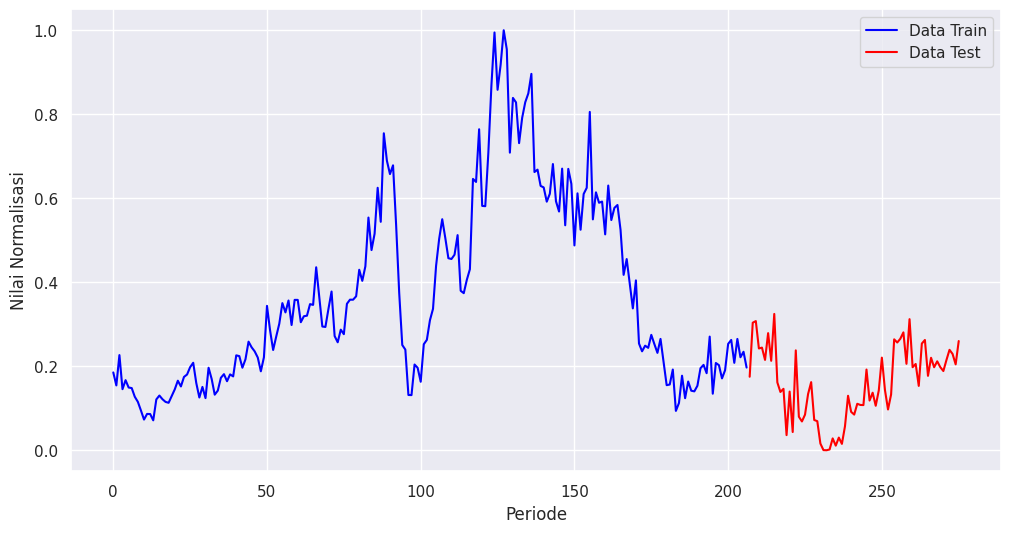

In [13]:
plt.figure(figsize=(12, 6))

bagi_train = int(len(scaled_data)*0.75)
bagi_test = len(scaled_data) - bagi_train
Xnorm_train, Xnorm_test = scaled_data[:bagi_train, :], scaled_data[bagi_train:, :]

# Plot X_train setelah normalisasi
plt.plot(range(len(Xnorm_train)), Xnorm_train, color='blue', label='Data Train')

# Plot X_test setelah normalisasi (dimulai dari akhir X_train)
plt.plot(range(len(Xnorm_train), len(Xnorm_train) + len(Xnorm_test)), Xnorm_test, color='red', label='Data Test')

# Menambahkan label dan legenda
plt.xlabel('Periode')
plt.ylabel('Nilai Normalisasi')
plt.legend()
plt.grid(True)
plt.show()

In [14]:
# Time series cross-validation
tscv = TimeSeriesSplit(n_splits=5)

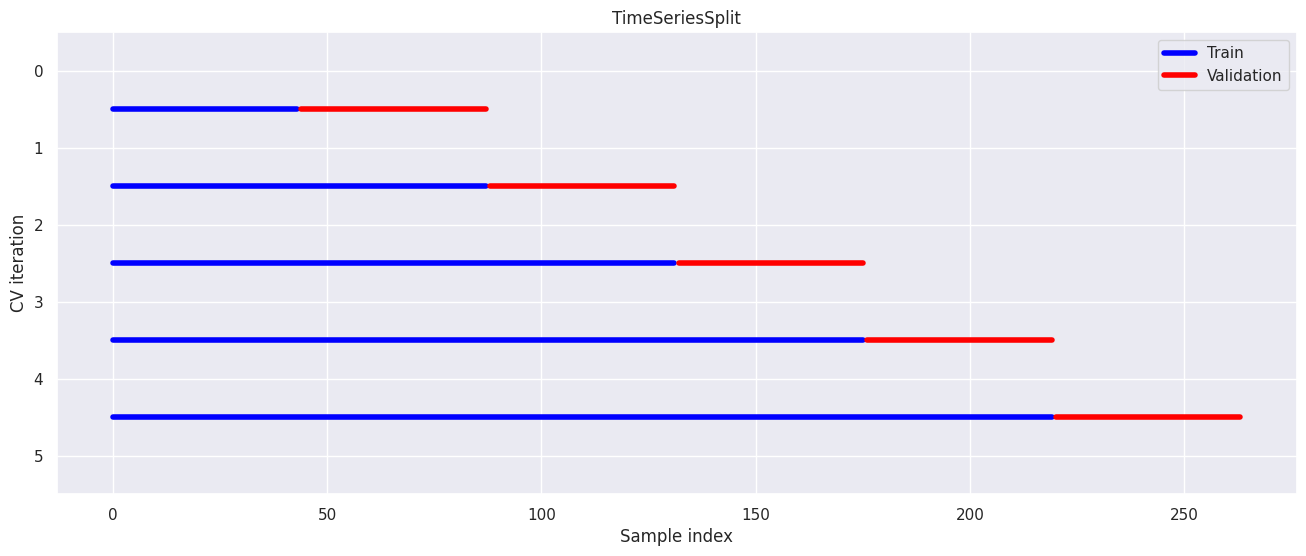

In [15]:
# Visualisasi TimeSeriesSplit
def plot_time_series_cv(tscv, X):
    plt.figure(figsize=(16, 6))
    for i, (train_index, test_index) in enumerate(tscv.split(X)):
        indices = np.arange(len(X))
        plt.plot(indices[train_index], [i + 0.5] * len(train_index), color = 'blue', linewidth = '4.0', label='Train' if i == 0 else '')
        plt.plot(indices[test_index], [i + 0.5] * len(test_index), color = 'red', linewidth = '4.0', label='Validation' if i == 0 else '')
    plt.ylim(-0.5, tscv.get_n_splits(X) + 0.5)
    plt.title('TimeSeriesSplit')
    plt.xlabel('Sample index')
    plt.ylabel('CV iteration')
    plt.legend(loc='best')
    plt.gca().invert_yaxis()  # Invert the y-axis to have the smallest CV iteration at the top
    plt.show()

# Plot the TimeSeriesSplit
plot_time_series_cv(tscv, X)

In [16]:
# Define early stopping
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='loss', patience=20)

In [17]:
def objective(trial):
    # Define the search space
    lstm_units_1 = trial.suggest_categorical('lstm_units_1', [32, 64, 128])
    lstm_units_2 = trial.suggest_categorical('lstm_units_2', [32, 64, 128])
    dropout_rate_1 = trial.suggest_categorical('dropout_rate_1', [0.1, 0.2, 0.3, 0.4, 0.5])
    dropout_rate_2 = trial.suggest_categorical('dropout_rate_2', [0.1, 0.2, 0.3, 0.4, 0.5])
    learning_rate = trial.suggest_categorical('learning_rate', [1e-3, 1e-2, 1e-1])
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])
    epochs = trial.suggest_int('epochs', 50, 200, 50)
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'RMSprop', 'SGD'])

    # Cross-validation scores
    cv_scores = []

    for train_index, val_index in tscv.split(X_train):
        X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
        y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

        # Build the model with 2 hidden layers
        model = Sequential([
            LSTM(units=lstm_units_1, return_sequences=True, input_shape=(X_train_fold.shape[1], 1)),
            Dropout(dropout_rate_1),
            LSTM(units=lstm_units_2),
            Dropout(dropout_rate_2),
            Dense(1)
        ])

        # Select optimizer
        if optimizer_name == 'Adam':
            optimizer = Adam(learning_rate=learning_rate)
        elif optimizer_name == 'RMSprop':
            optimizer = RMSprop(learning_rate=learning_rate)
        else:
            optimizer = SGD(learning_rate=learning_rate)

        model.compile(optimizer=optimizer, loss='mse')

        # Define early stopping
        early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

        # Fit the model
        history = model.fit(X_train_fold, y_train_fold,
                            validation_data=(X_val_fold, y_val_fold),
                            epochs=epochs,
                            batch_size=batch_size,
                            callbacks=[early_stopping],
                            verbose=0)

        # Evaluate the model
        val_pred = model.predict(X_val_fold)
        mse = mean_squared_error(y_val_fold, val_pred)
        cv_scores.append(mse)

    return np.mean(cv_scores)

In [18]:
# Create a study object and optimize the objective function
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

# Print the best parameters
print('Best parameters:', study.best_params)
print('Best value:', study.best_value)

[I 2024-08-15 09:38:10,183] A new study created in memory with name: no-name-6a8abb8a-fa14-4e79-96f9-a88a4f37ec19


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 272ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 276ms/step


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 279ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 270ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 271ms/step


[I 2024-08-15 09:40:01,955] Trial 0 finished with value: 0.0479462593793869 and parameters: {'lstm_units_1': 64, 'lstm_units_2': 128, 'dropout_rate_1': 0.4, 'dropout_rate_2': 0.2, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 200, 'optimizer': 'SGD'}. Best is trial 0 with value: 0.0479462593793869.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 280ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 266ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 424ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 278ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 274ms/step


[I 2024-08-15 09:41:05,676] Trial 1 finished with value: 0.02316609025001526 and parameters: {'lstm_units_1': 32, 'lstm_units_2': 32, 'dropout_rate_1': 0.5, 'dropout_rate_2': 0.5, 'learning_rate': 0.1, 'batch_size': 32, 'epochs': 200, 'optimizer': 'SGD'}. Best is trial 1 with value: 0.02316609025001526.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 274ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 281ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 283ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 269ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 283ms/step


[I 2024-08-15 09:42:02,994] Trial 2 finished with value: 0.023837391287088394 and parameters: {'lstm_units_1': 64, 'lstm_units_2': 64, 'dropout_rate_1': 0.1, 'dropout_rate_2': 0.1, 'learning_rate': 0.1, 'batch_size': 32, 'epochs': 100, 'optimizer': 'SGD'}. Best is trial 1 with value: 0.02316609025001526.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 280ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 274ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 264ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 275ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 275ms/step


[I 2024-08-15 09:42:42,622] Trial 3 finished with value: 0.04990852624177933 and parameters: {'lstm_units_1': 64, 'lstm_units_2': 64, 'dropout_rate_1': 0.5, 'dropout_rate_2': 0.3, 'learning_rate': 0.1, 'batch_size': 128, 'epochs': 150, 'optimizer': 'Adam'}. Best is trial 1 with value: 0.02316609025001526.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 287ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 286ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 433ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 290ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 289ms/step


[I 2024-08-15 09:43:22,489] Trial 4 finished with value: 0.031214222311973572 and parameters: {'lstm_units_1': 64, 'lstm_units_2': 128, 'dropout_rate_1': 0.3, 'dropout_rate_2': 0.4, 'learning_rate': 0.1, 'batch_size': 128, 'epochs': 200, 'optimizer': 'RMSprop'}. Best is trial 1 with value: 0.02316609025001526.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 271ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 275ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 275ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 328ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 277ms/step


[I 2024-08-15 09:44:02,860] Trial 5 finished with value: 0.014821251854300499 and parameters: {'lstm_units_1': 32, 'lstm_units_2': 32, 'dropout_rate_1': 0.5, 'dropout_rate_2': 0.1, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 100, 'optimizer': 'Adam'}. Best is trial 5 with value: 0.014821251854300499.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 279ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 272ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 278ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 430ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 271ms/step


[I 2024-08-15 09:44:44,898] Trial 6 finished with value: 0.016105564311146736 and parameters: {'lstm_units_1': 32, 'lstm_units_2': 64, 'dropout_rate_1': 0.2, 'dropout_rate_2': 0.1, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 200, 'optimizer': 'RMSprop'}. Best is trial 5 with value: 0.014821251854300499.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 281ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 283ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 278ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 280ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 411ms/step


[I 2024-08-15 09:45:29,942] Trial 7 finished with value: 0.017287466675043106 and parameters: {'lstm_units_1': 64, 'lstm_units_2': 128, 'dropout_rate_1': 0.1, 'dropout_rate_2': 0.4, 'learning_rate': 0.1, 'batch_size': 128, 'epochs': 150, 'optimizer': 'Adam'}. Best is trial 5 with value: 0.014821251854300499.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 273ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 272ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 274ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 413ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 280ms/step


[I 2024-08-15 09:46:18,115] Trial 8 finished with value: 0.015815991908311844 and parameters: {'lstm_units_1': 128, 'lstm_units_2': 64, 'dropout_rate_1': 0.5, 'dropout_rate_2': 0.5, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 50, 'optimizer': 'Adam'}. Best is trial 5 with value: 0.014821251854300499.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 274ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 273ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 266ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 273ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 279ms/step


[I 2024-08-15 09:47:04,866] Trial 9 finished with value: 0.012067866511642933 and parameters: {'lstm_units_1': 128, 'lstm_units_2': 64, 'dropout_rate_1': 0.2, 'dropout_rate_2': 0.2, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 100, 'optimizer': 'Adam'}. Best is trial 9 with value: 0.012067866511642933.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 286ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 271ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 267ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 298ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 436ms/step


[I 2024-08-15 09:47:53,812] Trial 10 finished with value: 0.01500787865370512 and parameters: {'lstm_units_1': 128, 'lstm_units_2': 64, 'dropout_rate_1': 0.2, 'dropout_rate_2': 0.2, 'learning_rate': 0.001, 'batch_size': 64, 'epochs': 50, 'optimizer': 'Adam'}. Best is trial 9 with value: 0.012067866511642933.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 274ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 273ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 265ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 278ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 426ms/step


[I 2024-08-15 09:48:33,111] Trial 11 finished with value: 0.011453627608716488 and parameters: {'lstm_units_1': 32, 'lstm_units_2': 32, 'dropout_rate_1': 0.2, 'dropout_rate_2': 0.1, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 100, 'optimizer': 'Adam'}. Best is trial 11 with value: 0.011453627608716488.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 270ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 418ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 286ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 271ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 302ms/step


[I 2024-08-15 09:49:20,466] Trial 12 finished with value: 0.01207971852272749 and parameters: {'lstm_units_1': 128, 'lstm_units_2': 32, 'dropout_rate_1': 0.2, 'dropout_rate_2': 0.2, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 100, 'optimizer': 'Adam'}. Best is trial 11 with value: 0.011453627608716488.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 298ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 279ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 285ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 273ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 277ms/step


[I 2024-08-15 09:50:08,323] Trial 13 finished with value: 0.012115503661334515 and parameters: {'lstm_units_1': 128, 'lstm_units_2': 32, 'dropout_rate_1': 0.2, 'dropout_rate_2': 0.3, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 100, 'optimizer': 'Adam'}. Best is trial 11 with value: 0.011453627608716488.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 274ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 286ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 289ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 270ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 276ms/step


[I 2024-08-15 09:50:46,347] Trial 14 finished with value: 0.013904084451496601 and parameters: {'lstm_units_1': 32, 'lstm_units_2': 32, 'dropout_rate_1': 0.2, 'dropout_rate_2': 0.2, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 50, 'optimizer': 'Adam'}. Best is trial 11 with value: 0.011453627608716488.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 277ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 304ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 286ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 279ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 285ms/step


[I 2024-08-15 09:51:43,368] Trial 15 finished with value: 0.012040361762046814 and parameters: {'lstm_units_1': 128, 'lstm_units_2': 64, 'dropout_rate_1': 0.4, 'dropout_rate_2': 0.1, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 150, 'optimizer': 'RMSprop'}. Best is trial 11 with value: 0.011453627608716488.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 270ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 271ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 279ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 275ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 337ms/step


[I 2024-08-15 09:52:24,376] Trial 16 finished with value: 0.012552207335829735 and parameters: {'lstm_units_1': 32, 'lstm_units_2': 32, 'dropout_rate_1': 0.4, 'dropout_rate_2': 0.1, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 150, 'optimizer': 'RMSprop'}. Best is trial 11 with value: 0.011453627608716488.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 269ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 278ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 270ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 269ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 275ms/step


[I 2024-08-15 09:53:19,154] Trial 17 finished with value: 0.0159635990858078 and parameters: {'lstm_units_1': 32, 'lstm_units_2': 64, 'dropout_rate_1': 0.4, 'dropout_rate_2': 0.1, 'learning_rate': 0.001, 'batch_size': 64, 'epochs': 150, 'optimizer': 'RMSprop'}. Best is trial 11 with value: 0.011453627608716488.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 275ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 278ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 450ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 290ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 282ms/step


[I 2024-08-15 09:53:58,976] Trial 18 finished with value: 0.019032161682844162 and parameters: {'lstm_units_1': 128, 'lstm_units_2': 32, 'dropout_rate_1': 0.3, 'dropout_rate_2': 0.1, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 150, 'optimizer': 'RMSprop'}. Best is trial 11 with value: 0.011453627608716488.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 349ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 270ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 273ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 262ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 279ms/step


[I 2024-08-15 09:54:41,913] Trial 19 finished with value: 0.015082861296832561 and parameters: {'lstm_units_1': 32, 'lstm_units_2': 128, 'dropout_rate_1': 0.4, 'dropout_rate_2': 0.1, 'learning_rate': 0.01, 'batch_size': 128, 'epochs': 100, 'optimizer': 'RMSprop'}. Best is trial 11 with value: 0.011453627608716488.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 274ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 283ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 271ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 274ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 333ms/step


[I 2024-08-15 09:55:59,326] Trial 20 finished with value: 0.013528411276638508 and parameters: {'lstm_units_1': 128, 'lstm_units_2': 32, 'dropout_rate_1': 0.4, 'dropout_rate_2': 0.1, 'learning_rate': 0.001, 'batch_size': 64, 'epochs': 150, 'optimizer': 'RMSprop'}. Best is trial 11 with value: 0.011453627608716488.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 278ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 415ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 269ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 267ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 267ms/step


[I 2024-08-15 09:56:44,059] Trial 21 finished with value: 0.01301517616957426 and parameters: {'lstm_units_1': 128, 'lstm_units_2': 64, 'dropout_rate_1': 0.2, 'dropout_rate_2': 0.2, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 100, 'optimizer': 'Adam'}. Best is trial 11 with value: 0.011453627608716488.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 344ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 287ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 288ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 278ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 390ms/step


[I 2024-08-15 09:57:31,031] Trial 22 finished with value: 0.012378745712339878 and parameters: {'lstm_units_1': 128, 'lstm_units_2': 64, 'dropout_rate_1': 0.2, 'dropout_rate_2': 0.3, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 100, 'optimizer': 'Adam'}. Best is trial 11 with value: 0.011453627608716488.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 291ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 270ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 272ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 279ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 294ms/step


[I 2024-08-15 09:58:13,380] Trial 23 finished with value: 0.05339791625738144 and parameters: {'lstm_units_1': 128, 'lstm_units_2': 64, 'dropout_rate_1': 0.2, 'dropout_rate_2': 0.5, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 50, 'optimizer': 'SGD'}. Best is trial 11 with value: 0.011453627608716488.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 275ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 293ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 320ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 277ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 264ms/step


[I 2024-08-15 09:58:57,580] Trial 24 finished with value: 0.015083922073245049 and parameters: {'lstm_units_1': 128, 'lstm_units_2': 64, 'dropout_rate_1': 0.3, 'dropout_rate_2': 0.4, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 100, 'optimizer': 'Adam'}. Best is trial 11 with value: 0.011453627608716488.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 282ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 270ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 280ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 270ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 280ms/step


[I 2024-08-15 09:59:37,045] Trial 25 finished with value: 0.015210112556815147 and parameters: {'lstm_units_1': 128, 'lstm_units_2': 64, 'dropout_rate_1': 0.1, 'dropout_rate_2': 0.2, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 150, 'optimizer': 'RMSprop'}. Best is trial 11 with value: 0.011453627608716488.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 275ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 282ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 294ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 285ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 279ms/step


[I 2024-08-15 10:00:29,924] Trial 26 finished with value: 0.010622593574225903 and parameters: {'lstm_units_1': 32, 'lstm_units_2': 64, 'dropout_rate_1': 0.4, 'dropout_rate_2': 0.1, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 100, 'optimizer': 'Adam'}. Best is trial 26 with value: 0.010622593574225903.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 273ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 275ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 269ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 266ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 278ms/step


[I 2024-08-15 10:01:07,905] Trial 27 finished with value: 0.01104036532342434 and parameters: {'lstm_units_1': 32, 'lstm_units_2': 64, 'dropout_rate_1': 0.4, 'dropout_rate_2': 0.1, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 50, 'optimizer': 'Adam'}. Best is trial 26 with value: 0.010622593574225903.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 276ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 273ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 265ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 268ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 274ms/step


[I 2024-08-15 10:01:48,209] Trial 28 finished with value: 0.015307645313441753 and parameters: {'lstm_units_1': 32, 'lstm_units_2': 128, 'dropout_rate_1': 0.4, 'dropout_rate_2': 0.1, 'learning_rate': 0.001, 'batch_size': 128, 'epochs': 50, 'optimizer': 'Adam'}. Best is trial 26 with value: 0.010622593574225903.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 277ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 404ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 264ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 268ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 270ms/step


[I 2024-08-15 10:02:23,927] Trial 29 finished with value: 0.05572478100657463 and parameters: {'lstm_units_1': 32, 'lstm_units_2': 32, 'dropout_rate_1': 0.4, 'dropout_rate_2': 0.1, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 50, 'optimizer': 'SGD'}. Best is trial 26 with value: 0.010622593574225903.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 277ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 267ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 266ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 280ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 270ms/step


[I 2024-08-15 10:03:08,544] Trial 30 finished with value: 0.012141690589487553 and parameters: {'lstm_units_1': 32, 'lstm_units_2': 128, 'dropout_rate_1': 0.4, 'dropout_rate_2': 0.1, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 50, 'optimizer': 'Adam'}. Best is trial 26 with value: 0.010622593574225903.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 274ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 265ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 295ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 282ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 426ms/step


[I 2024-08-15 10:03:58,070] Trial 31 finished with value: 0.01067318208515644 and parameters: {'lstm_units_1': 32, 'lstm_units_2': 64, 'dropout_rate_1': 0.4, 'dropout_rate_2': 0.1, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 100, 'optimizer': 'Adam'}. Best is trial 26 with value: 0.010622593574225903.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 278ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 420ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 280ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 287ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 276ms/step


[I 2024-08-15 10:04:42,712] Trial 32 finished with value: 0.01036418043076992 and parameters: {'lstm_units_1': 32, 'lstm_units_2': 64, 'dropout_rate_1': 0.4, 'dropout_rate_2': 0.1, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 100, 'optimizer': 'Adam'}. Best is trial 32 with value: 0.01036418043076992.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 271ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 268ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 272ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 416ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 282ms/step


[I 2024-08-15 10:05:20,967] Trial 33 finished with value: 0.01084369607269764 and parameters: {'lstm_units_1': 32, 'lstm_units_2': 64, 'dropout_rate_1': 0.4, 'dropout_rate_2': 0.1, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 100, 'optimizer': 'Adam'}. Best is trial 32 with value: 0.01036418043076992.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 268ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 275ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 311ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 280ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 271ms/step


[I 2024-08-15 10:06:12,000] Trial 34 finished with value: 0.02351517044007778 and parameters: {'lstm_units_1': 32, 'lstm_units_2': 64, 'dropout_rate_1': 0.4, 'dropout_rate_2': 0.1, 'learning_rate': 0.1, 'batch_size': 32, 'epochs': 100, 'optimizer': 'SGD'}. Best is trial 32 with value: 0.01036418043076992.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 270ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 278ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 266ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 410ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 267ms/step


[I 2024-08-15 10:06:50,449] Trial 35 finished with value: 0.010988330468535423 and parameters: {'lstm_units_1': 32, 'lstm_units_2': 64, 'dropout_rate_1': 0.4, 'dropout_rate_2': 0.5, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 100, 'optimizer': 'Adam'}. Best is trial 32 with value: 0.01036418043076992.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 281ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 273ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 286ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 283ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 268ms/step


[I 2024-08-15 10:07:24,216] Trial 36 finished with value: 0.018335144966840744 and parameters: {'lstm_units_1': 32, 'lstm_units_2': 64, 'dropout_rate_1': 0.4, 'dropout_rate_2': 0.1, 'learning_rate': 0.1, 'batch_size': 64, 'epochs': 100, 'optimizer': 'Adam'}. Best is trial 32 with value: 0.01036418043076992.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 305ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 443ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 294ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 294ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 302ms/step


[I 2024-08-15 10:08:13,467] Trial 37 finished with value: 0.013100783340632915 and parameters: {'lstm_units_1': 64, 'lstm_units_2': 64, 'dropout_rate_1': 0.4, 'dropout_rate_2': 0.3, 'learning_rate': 0.01, 'batch_size': 128, 'epochs': 100, 'optimizer': 'Adam'}. Best is trial 32 with value: 0.01036418043076992.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 280ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 434ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 282ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 291ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 280ms/step


[I 2024-08-15 10:09:15,946] Trial 38 finished with value: 0.04314187914133072 and parameters: {'lstm_units_1': 32, 'lstm_units_2': 64, 'dropout_rate_1': 0.1, 'dropout_rate_2': 0.1, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 100, 'optimizer': 'SGD'}. Best is trial 32 with value: 0.01036418043076992.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 280ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 292ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 283ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 289ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 491ms/step


[I 2024-08-15 10:09:54,464] Trial 39 finished with value: 0.01941056177020073 and parameters: {'lstm_units_1': 32, 'lstm_units_2': 64, 'dropout_rate_1': 0.5, 'dropout_rate_2': 0.4, 'learning_rate': 0.1, 'batch_size': 64, 'epochs': 100, 'optimizer': 'Adam'}. Best is trial 32 with value: 0.01036418043076992.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 282ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 282ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 276ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 272ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 282ms/step


[I 2024-08-15 10:10:37,396] Trial 40 finished with value: 0.011950386688113213 and parameters: {'lstm_units_1': 64, 'lstm_units_2': 64, 'dropout_rate_1': 0.4, 'dropout_rate_2': 0.1, 'learning_rate': 0.01, 'batch_size': 128, 'epochs': 200, 'optimizer': 'Adam'}. Best is trial 32 with value: 0.01036418043076992.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 422ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 280ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 278ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 285ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 422ms/step


[I 2024-08-15 10:11:22,380] Trial 41 finished with value: 0.012111186049878597 and parameters: {'lstm_units_1': 32, 'lstm_units_2': 64, 'dropout_rate_1': 0.4, 'dropout_rate_2': 0.5, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 100, 'optimizer': 'Adam'}. Best is trial 32 with value: 0.01036418043076992.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 276ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 425ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 277ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 286ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 278ms/step


[I 2024-08-15 10:12:05,044] Trial 42 finished with value: 0.011520651169121265 and parameters: {'lstm_units_1': 32, 'lstm_units_2': 64, 'dropout_rate_1': 0.4, 'dropout_rate_2': 0.5, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 100, 'optimizer': 'Adam'}. Best is trial 32 with value: 0.01036418043076992.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 277ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 277ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 289ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 319ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 330ms/step


[I 2024-08-15 10:12:55,902] Trial 43 finished with value: 0.0118064871057868 and parameters: {'lstm_units_1': 32, 'lstm_units_2': 64, 'dropout_rate_1': 0.4, 'dropout_rate_2': 0.5, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 100, 'optimizer': 'Adam'}. Best is trial 32 with value: 0.01036418043076992.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 307ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 303ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 390ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 289ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 283ms/step


[I 2024-08-15 10:13:47,954] Trial 44 finished with value: 0.011692643165588379 and parameters: {'lstm_units_1': 32, 'lstm_units_2': 64, 'dropout_rate_1': 0.4, 'dropout_rate_2': 0.5, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 100, 'optimizer': 'Adam'}. Best is trial 32 with value: 0.01036418043076992.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 291ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 286ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 324ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 292ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 399ms/step


[I 2024-08-15 10:14:33,485] Trial 45 finished with value: 0.01156673114746809 and parameters: {'lstm_units_1': 32, 'lstm_units_2': 64, 'dropout_rate_1': 0.5, 'dropout_rate_2': 0.5, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 100, 'optimizer': 'Adam'}. Best is trial 32 with value: 0.01036418043076992.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 272ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 401ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 279ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 277ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 274ms/step


[I 2024-08-15 10:15:19,802] Trial 46 finished with value: 0.01621866598725319 and parameters: {'lstm_units_1': 32, 'lstm_units_2': 64, 'dropout_rate_1': 0.3, 'dropout_rate_2': 0.4, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 100, 'optimizer': 'Adam'}. Best is trial 32 with value: 0.01036418043076992.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 278ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 273ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 275ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 275ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 271ms/step


[I 2024-08-15 10:16:13,086] Trial 47 finished with value: 0.02814839407801628 and parameters: {'lstm_units_1': 64, 'lstm_units_2': 128, 'dropout_rate_1': 0.4, 'dropout_rate_2': 0.1, 'learning_rate': 0.1, 'batch_size': 64, 'epochs': 100, 'optimizer': 'Adam'}. Best is trial 32 with value: 0.01036418043076992.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 381ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 280ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 282ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 386ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 272ms/step


[I 2024-08-15 10:16:52,970] Trial 48 finished with value: 0.011558815836906433 and parameters: {'lstm_units_1': 32, 'lstm_units_2': 64, 'dropout_rate_1': 0.1, 'dropout_rate_2': 0.3, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 150, 'optimizer': 'Adam'}. Best is trial 32 with value: 0.01036418043076992.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 278ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 277ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 289ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 313ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 271ms/step


[I 2024-08-15 10:17:32,111] Trial 49 finished with value: 0.010783033445477486 and parameters: {'lstm_units_1': 32, 'lstm_units_2': 64, 'dropout_rate_1': 0.4, 'dropout_rate_2': 0.1, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 100, 'optimizer': 'Adam'}. Best is trial 32 with value: 0.01036418043076992.


Best parameters: {'lstm_units_1': 32, 'lstm_units_2': 64, 'dropout_rate_1': 0.4, 'dropout_rate_2': 0.1, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 100, 'optimizer': 'Adam'}
Best value: 0.01036418043076992


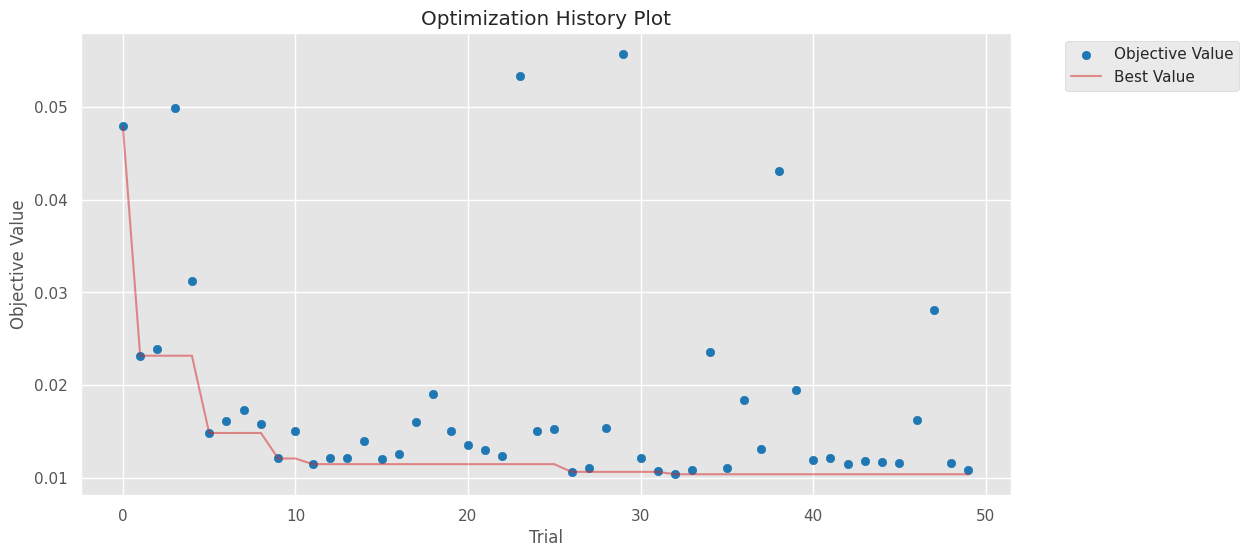

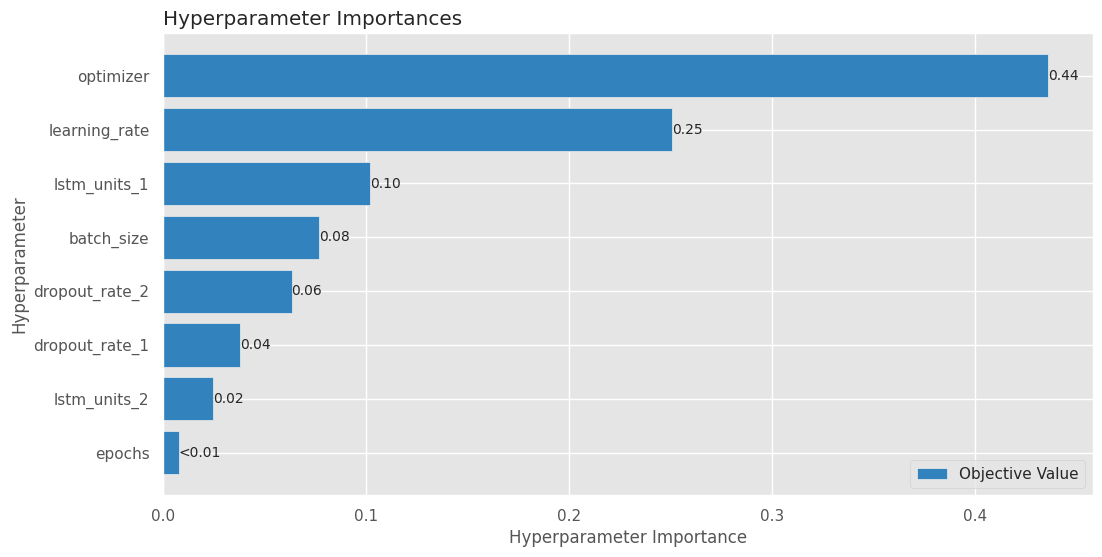

In [19]:
# Plot optimization history and parameter importances
plot_optimization_history(study)
plt.show()
plot_param_importances(study)
plt.show()

In [20]:
# Train final model with best parameters
best_params = study.best_params
model =  Sequential([
    LSTM(units=best_params['lstm_units_1'], return_sequences=True, input_shape=(X_train.shape[1], 1)),
    Dropout(best_params['dropout_rate_1']),
    LSTM(units=best_params['lstm_units_2']),
    Dropout(best_params['dropout_rate_2']),
    Dense(1)
])

# Select optimizer based on best parameters
if best_params['optimizer'] == 'Adam':
    optimizer = Adam(learning_rate=best_params['learning_rate'])
elif best_params['optimizer'] == 'RMSprop':
    optimizer = RMSprop(learning_rate=best_params['learning_rate'])
else:
    optimizer = SGD(learning_rate=best_params['learning_rate'])

model.compile(optimizer=optimizer, loss='mse')

# Train the model on the full training dataset
history = model.fit(X_train, y_train,
                    validation_split=0.2,
                    epochs=best_params['epochs'],
                    batch_size=best_params['batch_size'],
                    verbose=1)

Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 211ms/step - loss: 0.1896 - val_loss: 0.0075
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0511 - val_loss: 0.0232
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.1257 - val_loss: 0.0041
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0630 - val_loss: 0.0309
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0332 - val_loss: 0.0578
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0283 - val_loss: 0.0120
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0263 - val_loss: 0.0060
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0295 - val_loss: 0.0124
Epoch 9/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0213 - val_loss: 0.0279
Epoch 10/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0219 - val_loss: 0.0244
Epoch 11/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0176 - val_loss: 0.0095
Epoch 12/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0178 - val_l

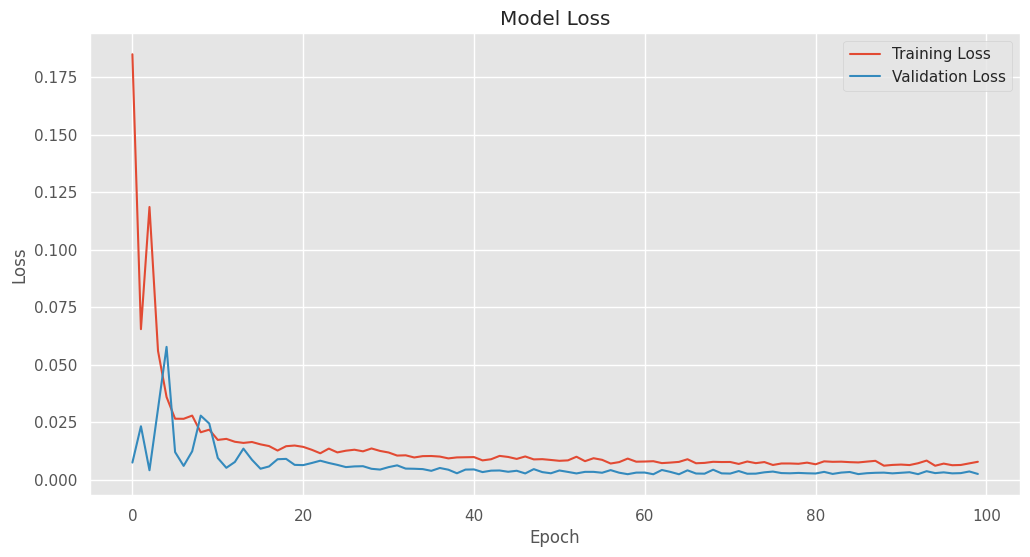

Average Loss: 0.0144


In [21]:
# Fungsi untuk plot training dan validation loss
def plot_loss(history):
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    plt.show()

plot_loss(history)

average_loss = np.mean(history.history['loss'])
print(f"Average Loss: {average_loss:.4f}")

In [22]:
# Make predictions on the training and testing datasets
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


In [23]:
# Inverse transform predictions and actual values
train_predictions = scaler.inverse_transform(train_predictions)
test_predictions = scaler.inverse_transform(test_predictions)
y_train_actual = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

In [24]:
# Define a function to calculate MAE, MAPE, and RMSE
def evaluate_prediction(predictions, actual, model_name):
    errors = predictions - actual
    mse = np.square(errors).mean()
    rmse = np.sqrt(mse)
    mae = np.abs(errors).mean()
    mape = np.mean(np.abs(errors / actual)) * 100  # Calculate MAPE

    print(model_name + ':')
    print('Mean Absolute Error: {:.3f}'.format(mae))
    print('Root Mean Square Error: {:.3f}'.format(rmse))
    print('Mean Absolute Percentage Error: {:.3f}%'.format(mape))
    print('')

In [25]:
# Evaluasi Model for Training Data
evaluate_prediction(train_predictions, y_train_actual, 'evaluasi model data train')

# Evaluasi Model for Testing Data
evaluate_prediction(test_predictions, y_test_actual, 'evaluasi model data test')

evaluasi model data train:
Mean Absolute Error: 186.317
Root Mean Square Error: 259.009
Mean Absolute Percentage Error: 9.494%

evaluasi model data test:
Mean Absolute Error: 161.460
Root Mean Square Error: 201.579
Mean Absolute Percentage Error: 15.352%



In [26]:
date_train = df['Tanggal'][time_steps:len(y_train_actual) + time_steps]
date_test = df['Tanggal'][-len(y_test_actual):]

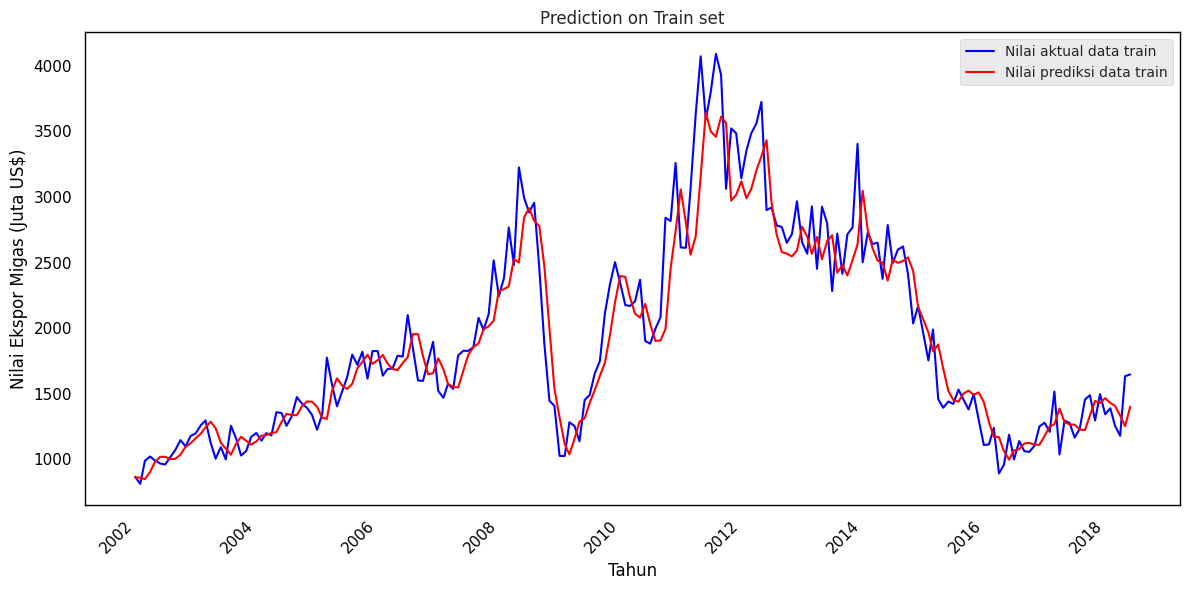

In [27]:
# Visualisasi prediksi vs aktual on train data
plt.figure(figsize=(12,6))
plt.title('Prediction on Train set', fontsize=12)
plt.xlabel('Tahun', fontsize=12, color='black')
plt.ylabel('Nilai Ekspor Migas (Juta US$)', fontsize=12, color='black')
plt.plot(date_train, y_train_actual, label='Nilai aktual data train', color='blue')
plt.plot(date_train, train_predictions, label='Nilai prediksi data train', color='red')
plt.legend(fontsize=10)
plt.xticks(rotation=45, ha='right', color='black')
plt.yticks(color='black')

# Mengatur latar belakang putih dan menghapus grid
plt.gca().set_facecolor('white')
plt.grid(False)

# Mengatur garis tepi
for spine in plt.gca().spines.values():
    spine.set_edgecolor('black')

plt.tight_layout()
plt.show()

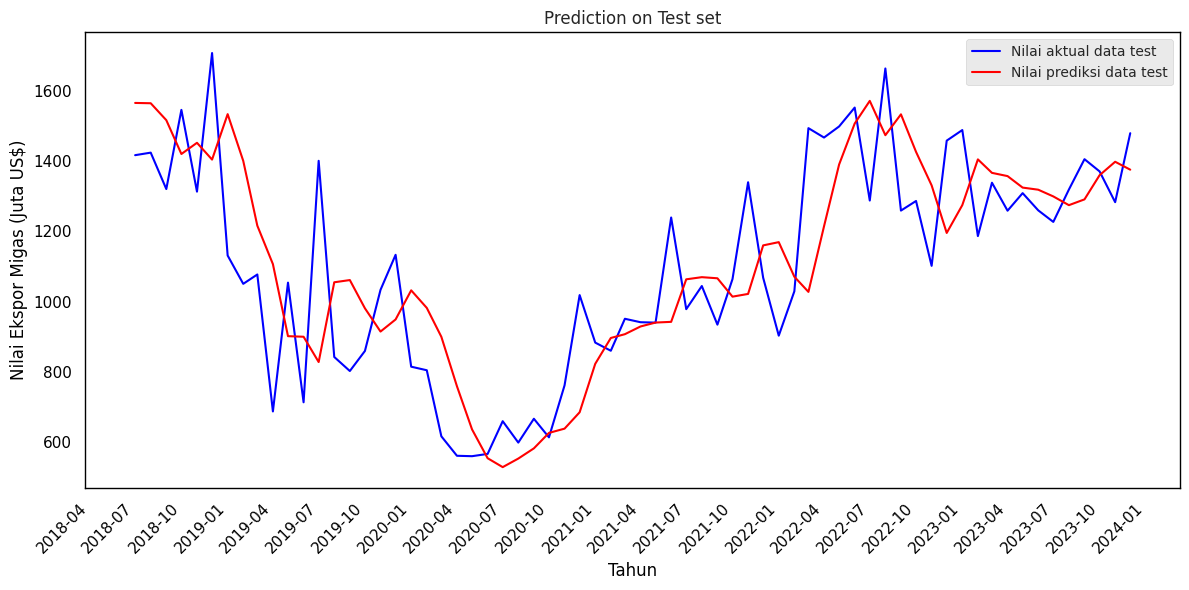

In [28]:
import matplotlib.dates as mdates

# Visualisasi prediksi vs aktual on test data
plt.figure(figsize=(12,6))
plt.title('Prediction on Test set', fontsize=12)
plt.xlabel('Tahun', fontsize=12, color='black')
plt.ylabel('Nilai Ekspor Migas (Juta US$)', fontsize=12, color='black')
plt.plot(date_test, y_test_actual, label='Nilai aktual data test', color='blue')
plt.plot(date_test, test_predictions, label='Nilai prediksi data test', color='red')

# Mengatur format tanggal
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# Rotate dates for better visibility
plt.xticks(rotation=45)  # Memutar label x-axis agar lebih mudah dibaca
plt.legend(fontsize=10)
plt.xticks(rotation=45, ha='right', color='black')
plt.yticks(color='black')

# Mengatur latar belakang putih dan menghapus grid
plt.gca().set_facecolor('white')
plt.grid(False)

# Mengatur garis tepi
for spine in plt.gca().spines.values():
    spine.set_edgecolor('black')

plt.tight_layout()
plt.show()

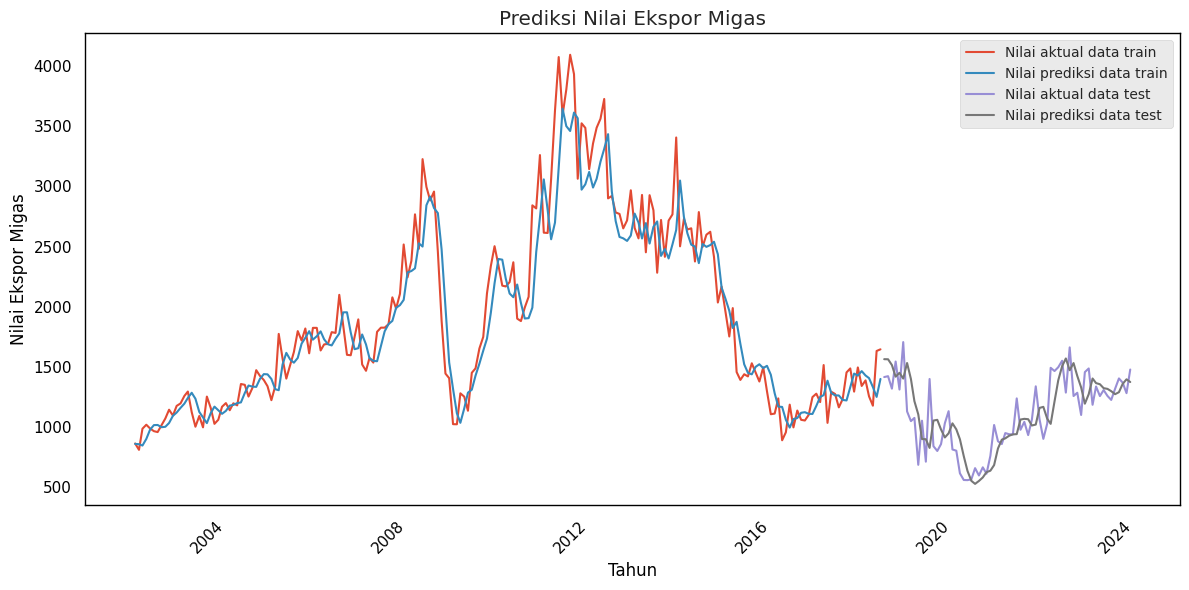

In [29]:
# Plot results
plt.figure(figsize=(12,6))
plt.plot(date_train, y_train_actual, label='Nilai aktual data train')
plt.plot(date_train, train_predictions, label='Nilai prediksi data train')
plt.plot(date_test, y_test_actual, label='Nilai aktual data test')
plt.plot(date_test, test_predictions, label='Nilai prediksi data test')
plt.title('Prediksi Nilai Ekspor Migas')
plt.xlabel('Tahun', color='black')
plt.ylabel('Nilai Ekspor Migas', color='black')
plt.legend(fontsize=10)
plt.legend()
plt.xticks(rotation=45, ha='right', color='black')
plt.yticks(color='black')
plt.legend(fontsize=10)

# Mengatur latar belakang putih dan menghapus grid
plt.gca().set_facecolor('white')
plt.grid(False)

# Mengatur garis tepi
for spine in plt.gca().spines.values():
    spine.set_edgecolor('black')

plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
      Tanggal  Nilai Ekspor Migas (Peramalan)
0  2024-01-01                     1422.742920
1  2024-02-01                     1443.869019
2  2024-03-01                     1461.960327
3  2024-04-01                     1474.133423
4  2024-05-01                     1485.768188
5  2024-06-01                     1495.663818
6  2024-07-01                     1506.035889
7  2024-08-01                     1517.141968
8  2024-09-01                     1527.423950
9  2024-10-01                     1537.002563
10 2024-11-01                     1

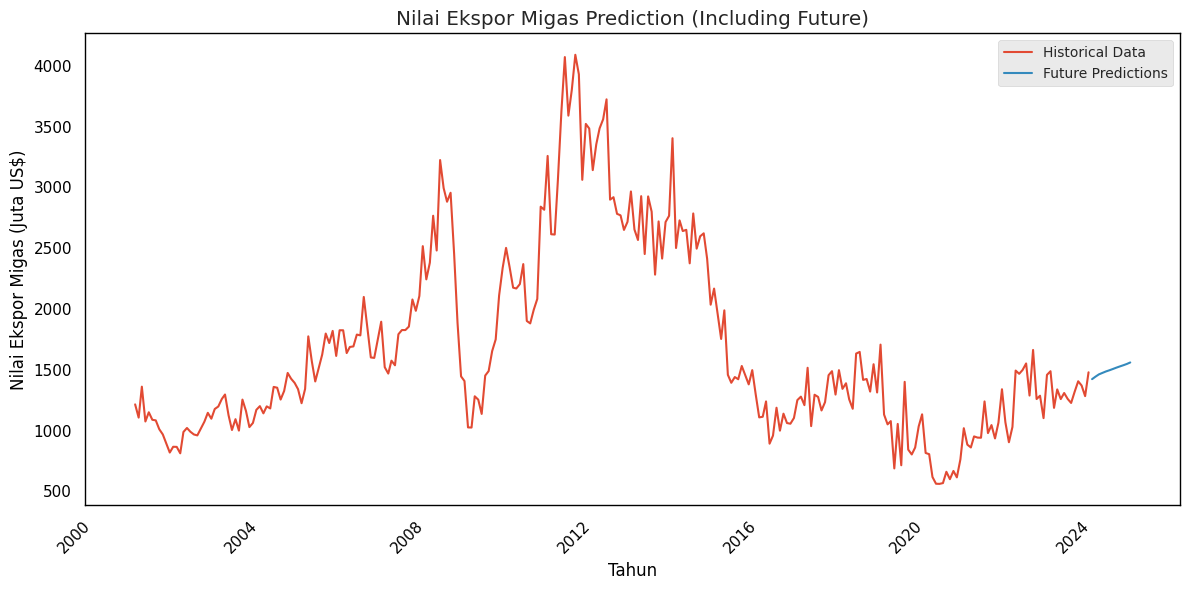

In [30]:
# Fungsi untuk melakukan peramalan
def forecast_future(model, last_data, periods, scaler):
    future_predictions = []
    current_batch = last_data

    for _ in range(periods):
        # Prediksi satu langkah ke depan
        current_pred = model.predict(current_batch)
        future_predictions.append(current_pred[0])

        # Update batch untuk prediksi berikutnya
        current_batch = np.roll(current_batch, -1, axis=1)
        current_batch[0, -1, 0] = current_pred[0]

    # Inverse transform hasil peramalan
    future_predictions = np.array(future_predictions).reshape(-1, 1)
    return scaler.inverse_transform(future_predictions)

# Ambil data terakhir untuk input peramalan
last_known_data = scaled_data[-time_steps:]
last_known_data = last_known_data.reshape((1, time_steps, 1))

# Lakukan peramalan untuk 12 periode ke depan
future_periods = 12
future_predictions = forecast_future(model, last_known_data, future_periods, scaler)

# Buat tanggal untuk hasil peramalan
last_date = df['Tanggal'].iloc[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=30), periods=future_periods, freq='MS')

# Buat DataFrame untuk hasil peramalan
forecast_df = pd.DataFrame({
    'Tanggal': future_dates,
    'Nilai Ekspor Migas (Peramalan)': future_predictions.flatten()
})

print(forecast_df)

# Plot future predictions
plt.figure(figsize=(12,6))
plt.plot(df['Tanggal'], df['Nilai Ekspor Migas'], label='Historical Data')
plt.plot(future_dates, future_predictions, label='Future Predictions')
plt.title('Nilai Ekspor Migas Prediction (Including Future)')
plt.xlabel('Tahun', fontsize=12, color='black')
plt.ylabel('Nilai Ekspor Migas (Juta US$)', fontsize=12, color='black')
plt.xticks(rotation=45, ha='right', color='black')
plt.yticks(color='black')
plt.legend(fontsize=10)

# Mengatur latar belakang putih dan menghapus grid
plt.gca().set_facecolor('white')
plt.grid(False)

# Mengatur garis tepi
for spine in plt.gca().spines.values():
    spine.set_edgecolor('black')

plt.tight_layout()

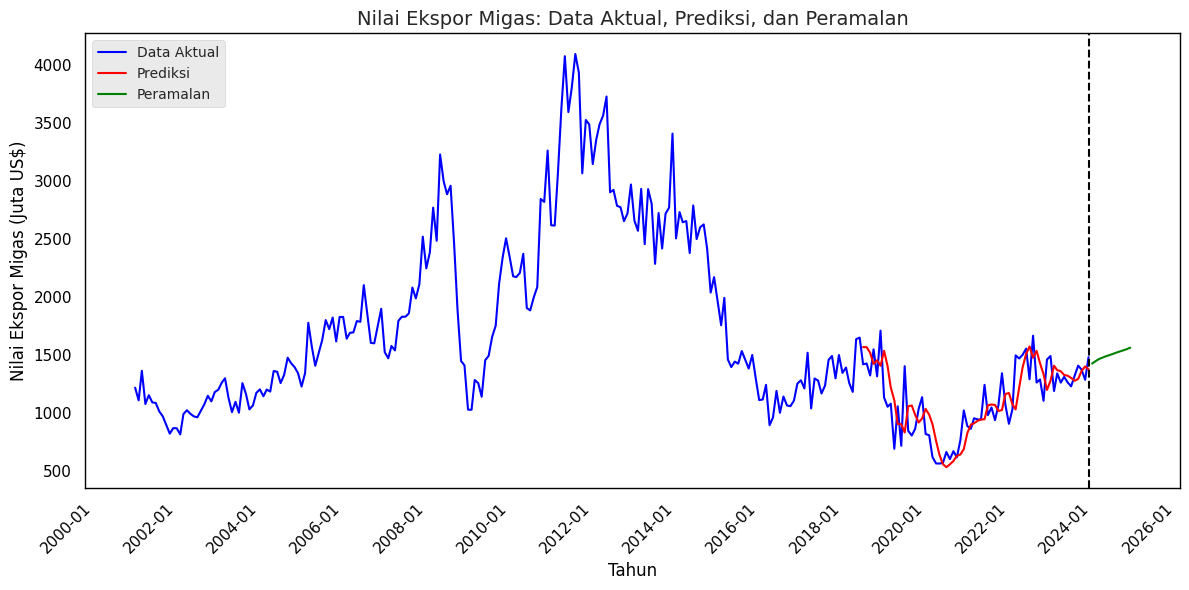

In [31]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import numpy as np

# Mengubah future_dates menjadi Series
future_dates_series = pd.Series(future_dates)

# Menggabungkan data aktual, prediksi data uji, dan hasil peramalan
all_dates = pd.concat([df['Tanggal'], future_dates_series])
all_actual = pd.concat([df['Nilai Ekspor Migas'], pd.Series([np.nan] * len(future_dates))])
all_predictions = np.concatenate([np.array([np.nan] * (len(df) - len(test_predictions))),
                                  test_predictions.flatten(),
                                  future_predictions.flatten()])

# Membuat plot
plt.figure(figsize=(12, 6))
plt.plot(all_dates, all_actual, label='Data Aktual', color='blue')

# Garis prediksi
plt.plot(all_dates[-len(test_predictions)-len(future_predictions):-len(future_predictions)],
         all_predictions[-len(test_predictions)-len(future_predictions):-len(future_predictions)],
         label='Prediksi', color='red')

# Garis peramalan
plt.plot(all_dates[-len(future_predictions):],
         all_predictions[-len(future_predictions):],
         label='Peramalan', color='green')

# Menambahkan garis vertikal untuk memisahkan data uji dan peramalan
split_date = df['Tanggal'].iloc[-1]
plt.axvline(x=split_date, color='black', linestyle='--')

plt.title('Nilai Ekspor Migas: Data Aktual, Prediksi, dan Peramalan', fontsize=14)
plt.xlabel('Tahun', fontsize=12, color='black')
plt.ylabel('Nilai Ekspor Migas (Juta US$)', fontsize=12, color='black')

# Mengatur format tanggal pada sumbu x
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.YearLocator(base=2))

plt.xticks(rotation=45, ha='right', color='black')
plt.yticks(color='black')
plt.legend(fontsize=10)

# Mengatur latar belakang putih dan menghapus grid
plt.gca().set_facecolor('white')
plt.grid(False)

# Mengatur garis tepi
for spine in plt.gca().spines.values():
    spine.set_edgecolor('black')

plt.tight_layout()
plt.show()

In [32]:
!pip install openpyxl

In [33]:
forecast_df.to_excel('forecast_data75_h2t12.xlsx', index=False)
from google.colab import files
files.download('forecast_data75_h2t12.xlsx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [34]:
import numpy as np
import pandas as pd

# Konversi y_train_actual, train_predictions, y_test_actual, dan test_predictions ke array satu dimensi
y_train_actual = np.array(y_train_actual).flatten()
train_predictions = np.array(train_predictions).flatten()
y_test_actual = np.array(y_test_actual).flatten()
test_predictions = np.array(test_predictions).flatten()

# Buat DataFrame untuk nilai aktual dan prediksi data train
# Membuat DataFrame hasil untuk training dan testing
train_df = pd.DataFrame({
    'Tanggal': date_train.reset_index(drop=True),
    'Data Aktual': y_train_actual,
    'Data Prediksi': train_predictions
})

# Buat DataFrame untuk nilai aktual dan prediksi data test
test_df = pd.DataFrame({
    'Tanggal': date_test.reset_index(drop=True),
    'Data Aktual': y_test_actual,
    'Data Prediksi': test_predictions
})

# Gabungkan train_df dan test_df menjadi satu DataFrame
prediksi_df = pd.concat([train_df, test_df])

# Simpan DataFrame ke dalam file Excel
prediksi_df.to_excel('prediksi_data75_h2t12.xlsx', index=False)

# Jika Anda menggunakan Google Colab, Anda dapat mengunduh file Excel
from google.colab import files
files.download('prediksi_data75_h2t12.xlsx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>